In [1]:
import os
import sqlite3
import math

import numpy as np
import pandas as pd

db_path = os.path.join(os.path.dirname("__file__"), "..", "..", "data", "ufc.db")

In [2]:
query = """
WITH stances_imputed AS (
    SELECT
        t1.id AS fighter_id,
        CASE
            WHEN t1.stance IS NOT NULL THEN t1.stance
            WHEN t3.stance IS NOT NULL THEN t3.stance
            WHEN t4.stance IS NOT NULL AND t4.stance LIKE 'Switches%' THEN 'Switch'
            WHEN t4.stance IS NOT NULL THEN t4.stance
            ELSE 'Unknown'
        END AS stance
    FROM
        ufcstats_fighters AS t1
    INNER JOIN fighter_mapping AS t2 ON t1.id = t2.ufcstats_id
    LEFT JOIN fightoddsio_fighters AS t3 ON t2.fightoddsio_id = t3.id
    LEFT JOIN betmma_fighters AS t4 ON t2.betmma_id = t4.id
),
nationalities AS (
    SELECT
        t2.ufcstats_id AS fighter_id,
        CASE
            WHEN t1.nationality = 'USA' THEN 'united states'
            WHEN t1.nationality IS NULL THEN 'unknown'
            ELSE LOWER(t1.nationality)
        END AS nationality
    FROM
        sherdog_fighters AS t1
    INNER JOIN fighter_mapping AS t2 ON t1.id = t2.sherdog_id
),
cte1 AS (
    SELECT
        fighter_id,
        bout_id,
        CASE
            WHEN gym_id IS NOT NULL THEN gym_id
            ELSE gym_name
        END AS gym_id,
        ROW_NUMBER() OVER (PARTITION BY fighter_id, bout_id ORDER BY t1.rowid) AS gym_rank
    FROM
        tapology_fighter_gyms t1
    WHERE
        gym_purpose = 'Primary'
),
cte2 AS (
    SELECT
        *,
        ROW_NUMBER() OVER (PARTITION BY fighter_id, bout_id ORDER BY gym_rank) AS primary_gym_rank
    FROM
        cte1 AS t1
),
cte3 AS (
    SELECT
        *
    FROM cte2
    WHERE primary_gym_rank = 1
),
cte4 AS (
    SELECT
        t1.fighter_id,
        t1.bout_id,
        CASE
            WHEN t1.gym_id IS NOT NULL THEN t1.gym_id
            ELSE t1.gym_name
        END AS gym_id,
        COUNT(t1.gym_name) OVER (PARTITION BY t1.fighter_id, t1.bout_id) AS gym_count,
        ROW_NUMBER() OVER (PARTITION BY t1.fighter_id, t1.bout_id ORDER BY t1.rowid) AS gym_rank
    FROM
        tapology_fighter_gyms AS t1
),
cte5 AS (
    SELECT
        t1.fighter_id,
        t1.bout_id,
        t1.gym_id,
        t1.gym_count,
        t1.gym_rank,
        CASE
            WHEN t2.fighter_id IS NOT NULL AND t2.bout_id IS NOT NULL THEN 1
            ELSE 0
        END AS has_primary_flag,
        t3.primary_gym_rank
    FROM
        cte4 AS t1
    LEFT JOIN cte3 AS t2 ON t1.fighter_id = t2.fighter_id AND t1.bout_id = t2.bout_id
    LEFT JOIN cte3 AS t3 ON t1.fighter_id = t3.fighter_id AND t1.bout_id = t3.bout_id AND t1.gym_id = t3.gym_id
),
cte6 AS (
    SELECT
        fighter_id,
        bout_id,
        gym_id
    FROM
        cte5
    WHERE
        gym_count = 1
    UNION
    SELECT
        fighter_id,
        bout_id,
        gym_id
    FROM
        cte5
    WHERE
        gym_count > 1 AND has_primary_flag = 1 AND primary_gym_rank = 1
    UNION
    SELECT
        fighter_id,
        bout_id,
        gym_id
    FROM
        cte5
    WHERE
        gym_count > 1 AND has_primary_flag = 0 AND gym_rank = 1
),
fighter_gyms AS (
    SELECT
        t2.ufcstats_id AS fighter_id,
        t3.ufcstats_id AS bout_id,
        CASE
            WHEN t4.parent_id IS NOT NULL THEN t4.parent_id
            ELSE t1.gym_id
        END AS gym_id
    FROM
        cte6 AS t1
    INNER JOIN fighter_mapping AS t2 ON t1.fighter_id = t2.tapology_id
    INNER JOIN bout_mapping AS t3 ON t1.bout_id = t3.tapology_id
    LEFT JOIN tapology_gyms AS t4 ON t1.gym_id = t4.id
),
fighting_styles AS (
    SELECT
        t1.ufcstats_id AS fighter_id,
        CASE
            WHEN t2.fighting_style IS NOT NULL THEN t2.fighting_style
            ELSE 'Unknown'
        END AS fighting_style
    FROM
        fighter_mapping AS t1
    LEFT JOIN fightoddsio_fighters AS t2 ON t1.fightoddsio_id = t2.id
),
cte7 AS (
    SELECT
        t1.fighter_id,
        t1.bout_id,
        t1.opponent_id,
        CASE
            WHEN t3.weight_class = 'Catch Weight' THEN NULL
            WHEN t3.weight_class LIKE 'Women%' THEN 1
            ELSE 0
        END AS is_female
    FROM
        ufcstats_fighter_histories AS t1
    INNER JOIN bout_mapping AS t2 ON t1.bout_id = t2.ufcstats_id
    LEFT JOIN ufcstats_bouts AS t3 ON t1.bout_id = t3.id
),
cte8 AS (
    SELECT
        fighter_id,
        bout_id,
        opponent_id,
        MAX(is_female) OVER (PARTITION BY fighter_id) AS is_female
    FROM
        cte7
),
cte9 AS (
    SELECT
        t1.fighter_id,
        t1.bout_id,
        t1.opponent_id,
        CASE
            WHEN t1.is_female = 1 OR t2.is_female = 1 THEN 1
            WHEN t1.is_female IS NULL AND t2.is_female IS NULL THEN NULL
            ELSE 0
        END AS is_female
    FROM
        cte8 AS t1
    LEFT JOIN cte8 AS t2 ON t1.opponent_id = t2.fighter_id AND t1.bout_id = t2.bout_id AND t1.fighter_id = t2.opponent_id
),
fighter_genders AS (
    SELECT
        fighter_id,
        is_female
    FROM
        cte9
    GROUP BY fighter_id
),
cte10 AS (
    SELECT
        t1.id,
        t3.wikipedia_id AS event_order,
        t1.bout_order,
        t17.date,
        CASE
            WHEN t1.red_outcome = 'W' THEN 1
            ELSE 0
        END AS red_win_flag,
        CASE
            WHEN t1.red_outcome = 'L' THEN 1
            ELSE 0
        END AS red_loss_flag,
        CASE
            WHEN t4.weight_class_final_weight_lbs IS NOT NULL THEN t4.weight_class_final_weight_lbs
            WHEN t1.weight_class = 'Heavyweight' THEN 265
            WHEN t1.weight_class = 'Featherweight' THEN 145
            ELSE NULL
        END AS weight_class_weight_lbs,
        t1.weight_class,
        CASE 
            WHEN t1.type_verbose LIKE '%Title Bout' AND t1.type_verbose NOT LIKE '%Tournament%' THEN 1 
            ELSE 0 
        END AS is_title_bout,
        CASE
            WHEN t1.round_time_format = '5 Rnd (5-5-5-5-5)' THEN 1
            ELSE 0
        END AS is_five_rounds,
        t5.card_segment,
        CASE
            WHEN t6.is_female = 1 OR t7.is_female = 1 THEN 1
            ELSE 0
        END AS is_female,
        CONCAT(t8.stance, ' vs. ', t9.stance) AS stance_matchup,
        CONCAT(t10.fighting_style, ' vs. ', t11.fighting_style) AS fighting_style_matchup,
        CONCAT(t12.nationality, ' vs. ', t13.nationality) AS nationality_matchup,
        CONCAT(IFNULL(t14.gym_id, 'Unknown'), ' vs. ', IFNULL(t15.gym_id, 'Unknown')) AS gym_matchup,
        CASE
            WHEN t12.nationality = LOWER(t16.country) THEN 1
            ELSE 0
        END AS red_is_home_country,
        CASE
            WHEN t13.nationality = LOWER(t16.country) THEN 1
            ELSE 0
        END AS blue_is_home_country
    FROM
        ufcstats_bouts AS t1
    INNER JOIN bout_mapping AS t2 ON t1.id = t2.ufcstats_id
    INNER JOIN event_mapping AS t3 ON t1.event_id = t3.ufcstats_id
    INNER JOIN tapology_bouts AS t4 ON t2.tapology_id = t4.id
    INNER JOIN espn_bouts AS t5 ON t2.espn_id = t5.id
    LEFT JOIN fighter_genders AS t6 ON t1.red_fighter_id = t6.fighter_id
    LEFT JOIN fighter_genders AS t7 ON t1.blue_fighter_id = t7.fighter_id
    LEFT JOIN stances_imputed AS t8 ON t1.red_fighter_id = t8.fighter_id
    LEFT JOIN stances_imputed AS t9 ON t1.blue_fighter_id = t9.fighter_id
    LEFT JOIN fighting_styles AS t10 ON t1.red_fighter_id = t10.fighter_id
    LEFT JOIN fighting_styles AS t11 ON t1.blue_fighter_id = t11.fighter_id
    LEFT JOIN nationalities AS t12 ON t1.red_fighter_id = t12.fighter_id
    LEFT JOIN nationalities AS t13 ON t1.blue_fighter_id = t13.fighter_id
    LEFT JOIN fighter_gyms AS t14 ON t1.red_fighter_id = t14.fighter_id AND t1.id = t14.bout_id
    LEFT JOIN fighter_gyms AS t15 ON t1.blue_fighter_id = t15.fighter_id AND t1.id = t15.bout_id
    LEFT JOIN sherdog_events AS t16 ON t3.sherdog_id = t16.id
    INNER JOIN ufcstats_events AS t17 ON t1.event_id = t17.id
),
main_cte AS (
    SELECT
        id,
        event_order,
        bout_order,
        red_win_flag,
        red_loss_flag,
        weight_class_weight_lbs,
        weight_class,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        CONCAT(red_is_home_country, ' vs. ', blue_is_home_country) AS home_country_matchup
    FROM
        cte10
    WHERE date >= '2008-04-19'
),
temp AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        SUM(red_win_flag) OVER (
            PARTITION BY weight_class
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_win_count_by_weight_class,
        SUM(red_loss_flag) OVER (
            PARTITION BY weight_class
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_loss_count_by_weight_class,
        SUM(red_win_flag) OVER (
            PARTITION BY is_title_bout
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_win_count_by_is_title_bout,
        SUM(red_loss_flag) OVER (
            PARTITION BY is_title_bout
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_loss_count_by_is_title_bout,
        SUM(red_win_flag) OVER (
            PARTITION BY is_five_rounds
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_win_count_by_round_time_format,
        SUM(red_loss_flag) OVER (
            PARTITION BY is_five_rounds
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_loss_count_by_round_time_format,
        SUM(red_win_flag) OVER (
            PARTITION BY card_segment
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_win_count_by_card_segment,
        SUM(red_loss_flag) OVER (
            PARTITION BY card_segment
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_loss_count_by_card_segment,
        SUM(red_win_flag) OVER (
            PARTITION BY is_female
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_win_count_by_gender,
        SUM(red_loss_flag) OVER (
            PARTITION BY is_female
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_loss_count_by_gender,
        SUM(red_win_flag) OVER (
            PARTITION BY stance_matchup
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_win_count_by_stance_matchup,
        SUM(red_loss_flag) OVER (
            PARTITION BY stance_matchup
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_loss_count_by_stance_matchup,
        SUM(red_win_flag) OVER (
            PARTITION BY fighting_style_matchup
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_win_count_by_fighting_style_matchup,
        SUM(red_loss_flag) OVER (
            PARTITION BY fighting_style_matchup
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_loss_count_by_fighting_style_matchup,
        SUM(red_win_flag) OVER (
            PARTITION BY nationality_matchup
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_win_count_by_nationality_matchup,
        SUM(red_loss_flag) OVER (
            PARTITION BY nationality_matchup
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_loss_count_by_nationality_matchup,
        SUM(red_win_flag) OVER (
            PARTITION BY gym_matchup
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_win_count_by_gym_matchup,
        SUM(red_loss_flag) OVER (
            PARTITION BY gym_matchup
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_loss_count_by_gym_matchup,
        SUM(red_win_flag) OVER (
            PARTITION BY home_country_matchup
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_win_count_by_home_country_matchup,
        SUM(red_loss_flag) OVER (
            PARTITION BY home_country_matchup
            ORDER BY event_order, bout_order
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS red_loss_count_by_home_country_matchup
    FROM
        main_cte
),
woe_segmentation AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        LOG(
            1.0 * (IFNULL(red_win_count_by_weight_class, 0) + 0.0001) / (IFNULL(red_loss_count_by_weight_class, 0) + 0.0001)
        ) AS woe_by_weight_class,
        LOG(
            1.0 * (IFNULL(red_win_count_by_is_title_bout, 0) + 0.0001) / (IFNULL(red_loss_count_by_is_title_bout, 0) + 0.0001)
        ) AS woe_by_is_title_bout,
        LOG(
            1.0 * (IFNULL(red_win_count_by_round_time_format, 0) + 0.0001) / (IFNULL(red_loss_count_by_round_time_format, 0) + 0.0001)
        ) AS woe_by_round_time_format,
        LOG(
            1.0 * (IFNULL(red_win_count_by_card_segment, 0) + 0.0001) / (IFNULL(red_loss_count_by_card_segment, 0) + 0.0001)
        ) AS woe_by_card_segment,
        LOG(
            1.0 * (IFNULL(red_win_count_by_gender, 0) + 0.0001) / (IFNULL(red_loss_count_by_gender, 0) + 0.0001)
        ) AS woe_by_gender,
        LOG(
            1.0 * (IFNULL(red_win_count_by_stance_matchup, 0) + 0.0001) / (IFNULL(red_loss_count_by_stance_matchup, 0) + 0.0001)
        ) AS woe_by_stance_matchup,
        LOG(
            1.0 * (IFNULL(red_win_count_by_fighting_style_matchup, 0) + 0.0001) / (IFNULL(red_loss_count_by_fighting_style_matchup, 0) + 0.0001)
        ) AS woe_by_fighting_style_matchup,
        LOG(
            1.0 * (IFNULL(red_win_count_by_nationality_matchup, 0) + 0.0001) / (IFNULL(red_loss_count_by_nationality_matchup, 0) + 0.0001)
        ) AS woe_by_nationality_matchup,
        LOG(
            1.0 * (IFNULL(red_win_count_by_gym_matchup, 0) + 0.0001) / (IFNULL(red_loss_count_by_gym_matchup, 0) + 0.0001)
        ) AS woe_by_gym_matchup,
        LOG(
            1.0 * (IFNULL(red_win_count_by_home_country_matchup, 0) + 0.0001) / (IFNULL(red_loss_count_by_home_country_matchup, 0) + 0.0001)
        ) AS woe_by_home_country_matchup
    FROM
        temp
),
cte11 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class,
        woe_by_weight_class,
        ROW_NUMBER() OVER (PARTITION BY event_order, weight_class ORDER BY bout_order DESC) AS temp_rank
    FROM
        woe_segmentation
),
cte12 AS (
    SELECT
        event_order,
        weight_class,
        woe_by_weight_class
    FROM
        cte11
    WHERE temp_rank = 1
),
cte13 AS (
    SELECT
        t1.*,
        t2.woe_by_weight_class,
        ROW_NUMBER() OVER (PARTITION BY t1.id ORDER BY t2.event_order DESC) AS temp_rank
    FROM
        main_cte AS t1
    LEFT JOIN cte12 AS t2 ON t1.event_order > t2.event_order AND t1.weight_class = t2.weight_class
),
join1 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class_weight_lbs,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        woe_by_weight_class
    FROM
        cte13
    WHERE temp_rank = 1
),
cte14 AS (
    SELECT
        id,
        event_order,
        bout_order,
        is_title_bout,
        woe_by_is_title_bout,
        ROW_NUMBER() OVER (PARTITION BY event_order, is_title_bout ORDER BY bout_order DESC) AS temp_rank
    FROM
        woe_segmentation
),
cte15 AS (
    SELECT
        event_order,
        is_title_bout,
        woe_by_is_title_bout
    FROM
        cte14
    WHERE temp_rank = 1
),
cte16 AS (
    SELECT
        t1.*,
        t2.woe_by_is_title_bout,
        ROW_NUMBER() OVER (PARTITION BY t1.id ORDER BY t2.event_order DESC) AS temp_rank
    FROM
        join1 AS t1
    LEFT JOIN cte15 AS t2 ON t1.event_order > t2.event_order AND t1.is_title_bout = t2.is_title_bout
),
join2 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class_weight_lbs,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        woe_by_weight_class,
        woe_by_is_title_bout
    FROM
        cte16
    WHERE temp_rank = 1
),
cte17 AS (
    SELECT
        id,
        event_order,
        bout_order,
        is_five_rounds,
        woe_by_round_time_format,
        ROW_NUMBER() OVER (PARTITION BY event_order, is_five_rounds ORDER BY bout_order DESC) AS temp_rank
    FROM
        woe_segmentation
),
cte18 AS (
    SELECT
        event_order,
        is_five_rounds,
        woe_by_round_time_format
    FROM
        cte17
    WHERE temp_rank = 1
),
cte19 AS (
    SELECT
        t1.*,
        t2.woe_by_round_time_format,
        ROW_NUMBER() OVER (PARTITION BY t1.id ORDER BY t2.event_order DESC) AS temp_rank
    FROM
        join2 AS t1
    LEFT JOIN cte18 AS t2 ON t1.event_order > t2.event_order AND t1.is_five_rounds = t2.is_five_rounds
),
join3 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class_weight_lbs,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        woe_by_weight_class,
        woe_by_is_title_bout,
        woe_by_round_time_format
    FROM
        cte19
    WHERE temp_rank = 1
),
cte20 AS (
    SELECT
        id,
        event_order,
        bout_order,
        card_segment,
        woe_by_card_segment,
        ROW_NUMBER() OVER (PARTITION BY event_order, card_segment ORDER BY bout_order DESC) AS temp_rank
    FROM
        woe_segmentation
),
cte21 AS (
    SELECT
        event_order,
        card_segment,
        woe_by_card_segment
    FROM
        cte20
    WHERE temp_rank = 1
),
cte22 AS (
    SELECT
        t1.*,
        t2.woe_by_card_segment,
        ROW_NUMBER() OVER (PARTITION BY t1.id ORDER BY t2.event_order DESC) AS temp_rank
    FROM
        join3 AS t1
    LEFT JOIN cte21 AS t2 ON t1.event_order > t2.event_order AND t1.card_segment = t2.card_segment
),
join4 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class_weight_lbs,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        woe_by_weight_class,
        woe_by_is_title_bout,
        woe_by_round_time_format,
        woe_by_card_segment
    FROM
        cte22
    WHERE temp_rank = 1
),
cte23 AS (
    SELECT
        id,
        event_order,
        bout_order,
        is_female,
        woe_by_gender,
        ROW_NUMBER() OVER (PARTITION BY event_order, is_female ORDER BY bout_order DESC) AS temp_rank
    FROM
        woe_segmentation
),
cte24 AS (
    SELECT
        event_order,
        is_female,
        woe_by_gender
    FROM
        cte23
    WHERE temp_rank = 1
),
cte25 AS (
    SELECT
        t1.*,
        t2.woe_by_gender,
        ROW_NUMBER() OVER (PARTITION BY t1.id ORDER BY t2.event_order DESC) AS temp_rank
    FROM
        join4 AS t1
    LEFT JOIN cte24 AS t2 ON t1.event_order > t2.event_order AND t1.is_female = t2.is_female
),
join5 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class_weight_lbs,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        woe_by_weight_class,
        woe_by_is_title_bout,
        woe_by_round_time_format,
        woe_by_card_segment,
        woe_by_gender
    FROM
        cte25
    WHERE temp_rank = 1
),
cte26 AS (
    SELECT
        id,
        event_order,
        bout_order,
        stance_matchup,
        woe_by_stance_matchup,
        ROW_NUMBER() OVER (PARTITION BY event_order, stance_matchup ORDER BY bout_order DESC) AS temp_rank
    FROM
        woe_segmentation
),
cte27 AS (
    SELECT
        event_order,
        stance_matchup,
        woe_by_stance_matchup
    FROM
        cte26
    WHERE temp_rank = 1
),
cte28 AS (
    SELECT
        t1.*,
        t2.woe_by_stance_matchup,
        ROW_NUMBER() OVER (PARTITION BY t1.id ORDER BY t2.event_order DESC) AS temp_rank
    FROM
        join5 AS t1
    LEFT JOIN cte27 AS t2 ON t1.event_order > t2.event_order AND t1.stance_matchup = t2.stance_matchup
),
join6 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class_weight_lbs,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        woe_by_weight_class,
        woe_by_is_title_bout,
        woe_by_round_time_format,
        woe_by_card_segment,
        woe_by_gender,
        woe_by_stance_matchup
    FROM
        cte28
    WHERE temp_rank = 1
),
cte29 AS (
    SELECT
        id,
        event_order,
        bout_order,
        fighting_style_matchup,
        woe_by_fighting_style_matchup,
        ROW_NUMBER() OVER (PARTITION BY event_order, fighting_style_matchup ORDER BY bout_order DESC) AS temp_rank
    FROM
        woe_segmentation
),
cte30 AS (
    SELECT
        event_order,
        fighting_style_matchup,
        woe_by_fighting_style_matchup
    FROM
        cte29
    WHERE temp_rank = 1
),
cte31 AS (
    SELECT
        t1.*,
        t2.woe_by_fighting_style_matchup,
        ROW_NUMBER() OVER (PARTITION BY t1.id ORDER BY t2.event_order DESC) AS temp_rank
    FROM
        join6 AS t1
    LEFT JOIN cte30 AS t2 ON t1.event_order > t2.event_order AND t1.fighting_style_matchup = t2.fighting_style_matchup
),
join7 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class_weight_lbs,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        woe_by_weight_class,
        woe_by_is_title_bout,
        woe_by_round_time_format,
        woe_by_card_segment,
        woe_by_gender,
        woe_by_stance_matchup,
        woe_by_fighting_style_matchup
    FROM
        cte31
    WHERE temp_rank = 1
),
cte32 AS (
    SELECT
        id,
        event_order,
        bout_order,
        nationality_matchup,
        woe_by_nationality_matchup,
        ROW_NUMBER() OVER (PARTITION BY event_order, nationality_matchup ORDER BY bout_order DESC) AS temp_rank
    FROM
        woe_segmentation
),
cte33 AS (
    SELECT
        event_order,
        nationality_matchup,
        woe_by_nationality_matchup
    FROM
        cte32
    WHERE temp_rank = 1
),
cte34 AS (
    SELECT
        t1.*,
        t2.woe_by_nationality_matchup,
        ROW_NUMBER() OVER (PARTITION BY t1.id ORDER BY t2.event_order DESC) AS temp_rank
    FROM
        join7 AS t1
    LEFT JOIN cte33 AS t2 ON t1.event_order > t2.event_order AND t1.nationality_matchup = t2.nationality_matchup
),
join8 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class_weight_lbs,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        woe_by_weight_class,
        woe_by_is_title_bout,
        woe_by_round_time_format,
        woe_by_card_segment,
        woe_by_gender,
        woe_by_stance_matchup,
        woe_by_fighting_style_matchup,
        woe_by_nationality_matchup
    FROM
        cte34
    WHERE temp_rank = 1
),
cte35 AS (
    SELECT
        id,
        event_order,
        bout_order,
        gym_matchup,
        woe_by_gym_matchup,
        ROW_NUMBER() OVER (PARTITION BY event_order, gym_matchup ORDER BY bout_order DESC) AS temp_rank
    FROM
        woe_segmentation
),
cte36 AS (
    SELECT
        event_order,
        gym_matchup,
        woe_by_gym_matchup
    FROM
        cte35
    WHERE temp_rank = 1
),
cte37 AS (
    SELECT
        t1.*,
        t2.woe_by_gym_matchup,
        ROW_NUMBER() OVER (PARTITION BY t1.id ORDER BY t2.event_order DESC) AS temp_rank
    FROM
        join8 AS t1
    LEFT JOIN cte36 AS t2 ON t1.event_order > t2.event_order AND t1.gym_matchup = t2.gym_matchup
),
join9 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class_weight_lbs,
        is_title_bout,
        is_five_rounds,
        card_segment,
        is_female,
        stance_matchup,
        fighting_style_matchup,
        nationality_matchup,
        gym_matchup,
        home_country_matchup,
        woe_by_weight_class,
        woe_by_is_title_bout,
        woe_by_round_time_format,
        woe_by_card_segment,
        woe_by_gender,
        woe_by_stance_matchup,
        woe_by_fighting_style_matchup,
        woe_by_nationality_matchup,
        woe_by_gym_matchup
    FROM
        cte37
    WHERE temp_rank = 1
),
cte38 AS (
    SELECT
        id,
        event_order,
        bout_order,
        home_country_matchup,
        woe_by_home_country_matchup,
        ROW_NUMBER() OVER (PARTITION BY event_order, home_country_matchup ORDER BY bout_order DESC) AS temp_rank
    FROM
        woe_segmentation
),
cte39 AS (
    SELECT
        event_order,
        home_country_matchup,
        woe_by_home_country_matchup
    FROM
        cte38
    WHERE temp_rank = 1
),
cte40 AS (
    SELECT
        t1.*,
        t2.woe_by_home_country_matchup,
        ROW_NUMBER() OVER (PARTITION BY t1.id ORDER BY t2.event_order DESC) AS temp_rank
    FROM
        join9 AS t1
    LEFT JOIN cte39 AS t2 ON t1.event_order > t2.event_order AND t1.home_country_matchup = t2.home_country_matchup
),
join10 AS (
    SELECT
        id,
        event_order,
        bout_order,
        weight_class_weight_lbs,
        is_title_bout,
        is_five_rounds,
        is_female,
        woe_by_weight_class,
        woe_by_is_title_bout,
        woe_by_round_time_format,
        woe_by_card_segment,
        woe_by_gender,
        woe_by_stance_matchup,
        woe_by_fighting_style_matchup,
        woe_by_nationality_matchup,
        woe_by_gym_matchup,
        woe_by_home_country_matchup
    FROM
        cte40
    WHERE temp_rank = 1
    ORDER BY event_order, bout_order
)
SELECT
    t1.id,
    t2.weight_class_weight_lbs,
    t2.is_title_bout,
    t2.is_five_rounds,
    t2.is_female,
    IFNULL(woe_by_weight_class, 0) AS woe_by_weight_class,
    IFNULL(woe_by_is_title_bout, 0) AS woe_by_is_title_bout,
    IFNULL(woe_by_round_time_format, 0) AS woe_by_round_time_format,
    IFNULL(woe_by_card_segment, 0) AS woe_by_card_segment,
    IFNULL(woe_by_gender, 0) AS woe_by_gender,
    IFNULL(woe_by_stance_matchup, 0) AS woe_by_stance_matchup,
    IFNULL(woe_by_fighting_style_matchup, 0) AS woe_by_fighting_style_matchup,
    IFNULL(woe_by_nationality_matchup, 0) AS woe_by_nationality_matchup,
    IFNULL(woe_by_gym_matchup, 0) AS woe_by_gym_matchup,
    IFNULL(woe_by_home_country_matchup, 0) AS woe_by_home_country_matchup,
    CASE
        WHEN red_outcome = 'W' THEN 1
        ELSE 0
    END AS red_win
FROM ufcstats_bouts AS t1
LEFT JOIN join10 AS t2 ON t1.id = t2.id
WHERE t1.event_id IN (
    SELECT id FROM ufcstats_events
    WHERE is_ufc_event = 1 AND date >= '2008-04-19' AND date < '2021-01-01'
) AND red_outcome IN ('W', 'L') AND outcome_method != 'DQ'
"""

with sqlite3.connect(db_path) as conn:
    conn.create_function("LOG", 1, math.log)
    df = pd.read_sql_query(query, conn)
df

,id,weight_class_weight_lbs,is_title_bout,is_five_rounds,is_female,woe_by_weight_class,woe_by_is_title_bout,woe_by_round_time_format,woe_by_card_segment,woe_by_gender,woe_by_stance_matchup,woe_by_fighting_style_matchup,woe_by_nationality_matchup,woe_by_gym_matchup,woe_by_home_country_matchup,red_win
0,be38ed9ccfe2ee03,170,0,0,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1
1,eb1b371dfc37fcdb,265,0,0,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1
2,219bd976b8ca745d,155,0,0,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0
3,af178adff964d854,185,0,0,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0
4,920194911d727a38,185,0,0,0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4907,cd150cd28738a7c5,265,0,0,0,0.343333,0.326153,0.329311,0.45539,0.334324,0.334546,0.468834,-0.154149,0.00000,0.328640,1
4908,8955ea3c7c332e6c,135,0,0,0,0.396110,0.326153,0.329311,0.45539,0.334324,0.334546,0.326396,0.516491,0.00000,0.328640,0
4909,3d35eb2d46bf74de,170,0,0,0,0.263169,0.326153,0.329311,0.45539,0.334324,0.334546,0.214468,0.516491,0.00000,0.328640,1
4910,014f1da2083ca174,135,0,0,0,0.396110,0.326153,0.329311,0.45539,0.334324,0.179971,0.611800,9.903538,-9.21044,0.282167,1


In [4]:
query = """
WITH stances_imputed AS (
    SELECT
        t1.id AS fighter_id,
        CASE
            WHEN t1.stance IS NOT NULL THEN t1.stance
            WHEN t3.stance IS NOT NULL THEN t3.stance
            WHEN t4.stance IS NOT NULL AND t4.stance LIKE 'Switches%' THEN 'Switch'
            WHEN t4.stance IS NOT NULL THEN t4.stance
            ELSE 'Unknown'
        END AS stance
    FROM
        ufcstats_fighters AS t1
    INNER JOIN fighter_mapping AS t2 ON t1.id = t2.ufcstats_id
    LEFT JOIN fightoddsio_fighters AS t3 ON t2.fightoddsio_id = t3.id
    LEFT JOIN betmma_fighters AS t4 ON t2.betmma_id = t4.id
)
SELECT
    t1.id,
    CONCAT(t2.stance, ' vs. ', t3.stance) AS stance_matchup,
    CASE
        WHEN red_outcome = 'W' THEN 1
        ELSE 0
    END AS red_win
FROM ufcstats_bouts AS t1
LEFT JOIN stances_imputed AS t2 ON t1.red_fighter_id = t2.fighter_id
LEFT JOIN stances_imputed AS t3 ON t1.blue_fighter_id = t3.fighter_id
WHERE t1.event_id IN (
    SELECT id FROM ufcstats_events
    WHERE is_ufc_event = 1 AND date >= '2008-04-19'
) AND red_outcome IN ('W', 'L')
"""

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(query, conn)
df

,id,stance_matchup,red_win
0,be38ed9ccfe2ee03,Orthodox vs. Orthodox,1
1,eb1b371dfc37fcdb,Orthodox vs. Orthodox,1
2,219bd976b8ca745d,Orthodox vs. Southpaw,0
3,af178adff964d854,Orthodox vs. Southpaw,0
4,920194911d727a38,Orthodox vs. Orthodox,0
...,...,...,...
6940,5238f6470d0557fb,Orthodox vs. Orthodox,0
6941,7b1bc4ff776f12c1,Orthodox vs. Orthodox,0
6942,1a635a5e4551e7d5,Southpaw vs. Orthodox,1
6943,7521015554088962,Orthodox vs. Orthodox,1


Text(0, 0.5, 'Stance Matchup')

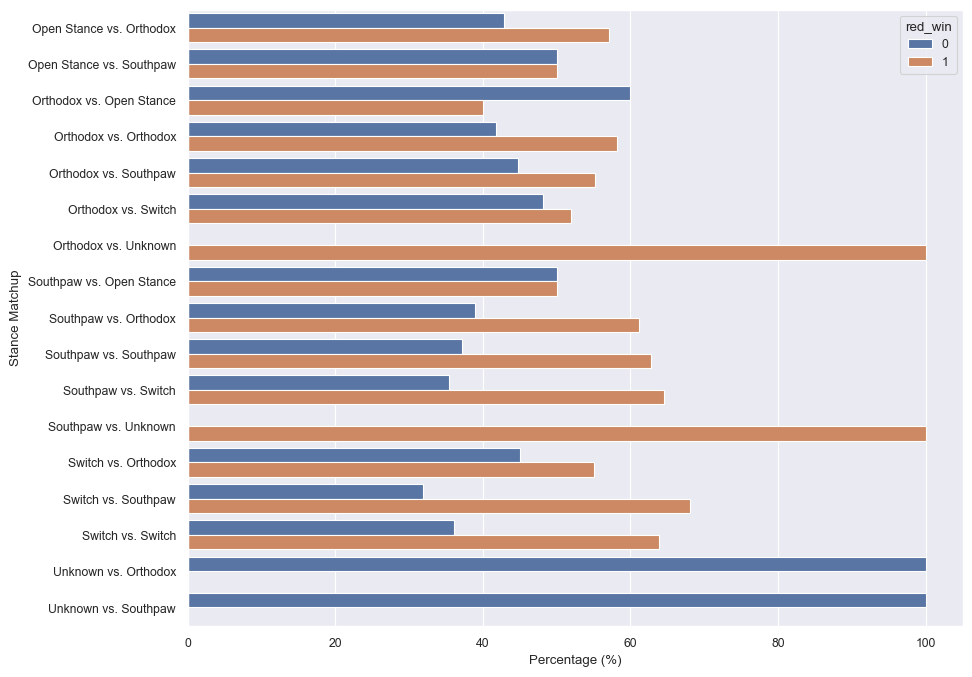

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))
sns.set_theme(style="darkgrid", context="paper")
# sns.countplot(x="stance_matchup", hue="red_win", data=df, ax=ax, stat="percent")

grouped_proportions = df.groupby(["stance_matchup", "red_win"]).size().unstack(fill_value=0)
grouped_proportions_normalized = grouped_proportions.div(grouped_proportions.sum(axis=1), axis=0) * 100

# grouped_proportions_normalized
# turn into long form
grouped_proportions_normalized = grouped_proportions_normalized.reset_index()
grouped_proportions_normalized = grouped_proportions_normalized.melt(id_vars="stance_matchup", var_name="red_win", value_name="proportion")
sns.barplot(x="proportion", y="stance_matchup", hue="red_win", data=grouped_proportions_normalized, ax=ax, orient="h")
ax.set_xlabel("Percentage (%)")
ax.set_ylabel("Stance Matchup")

In [26]:
query = """
SELECT
    t1.id,
    weight_class,
    CASE
        WHEN red_outcome = 'W' THEN 1
        ELSE 0
    END AS red_win
FROM ufcstats_bouts AS t1
WHERE t1.event_id IN (
    SELECT id FROM ufcstats_events
    WHERE is_ufc_event = 1 AND date >= '2008-04-19'
) AND red_outcome IN ('W', 'L')
"""

with sqlite3.connect(db_path) as conn:
    df = pd.read_sql_query(query, conn)
df

,id,weight_class,red_win
0,be38ed9ccfe2ee03,Welterweight,1
1,eb1b371dfc37fcdb,Heavyweight,1
2,219bd976b8ca745d,Lightweight,0
3,af178adff964d854,Middleweight,0
4,920194911d727a38,Middleweight,0
...,...,...,...
6940,5238f6470d0557fb,Bantamweight,0
6941,7b1bc4ff776f12c1,Light Heavyweight,0
6942,1a635a5e4551e7d5,Flyweight,1
6943,7521015554088962,Featherweight,1


Text(0, 0.5, 'Weight Class')

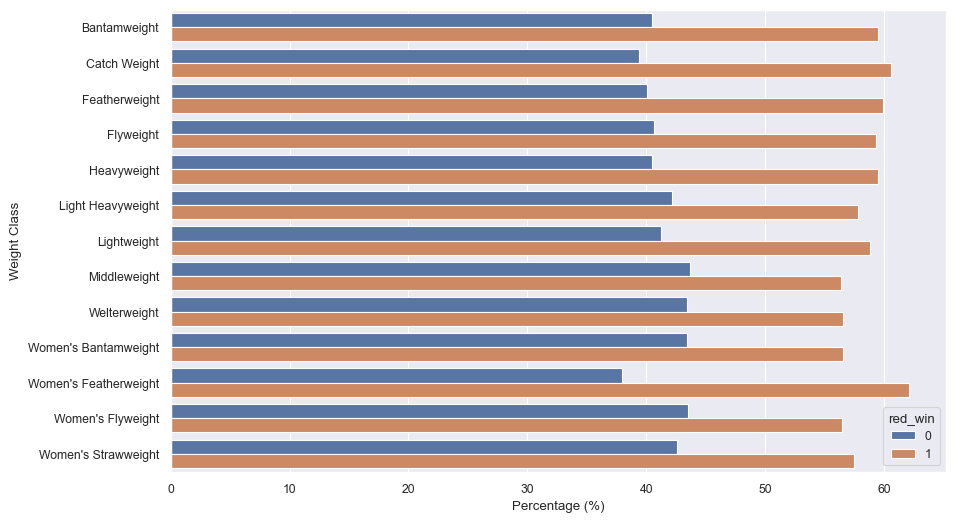

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.set_theme(style="darkgrid", context="paper")
# sns.countplot(x="stance_matchup", hue="red_win", data=df, ax=ax, stat="percent")

grouped_proportions = df.groupby(["weight_class", "red_win"]).size().unstack(fill_value=0)
grouped_proportions_normalized = grouped_proportions.div(grouped_proportions.sum(axis=1), axis=0) * 100

# grouped_proportions_normalized
# turn into long form
grouped_proportions_normalized = grouped_proportions_normalized.reset_index()
grouped_proportions_normalized = grouped_proportions_normalized.melt(id_vars="weight_class", var_name="red_win", value_name="proportion")
sns.barplot(x="proportion", y="weight_class", hue="red_win", data=grouped_proportions_normalized, ax=ax, orient="h")
ax.set_xlabel("Percentage (%)")
ax.set_ylabel("Weight Class")